# Final Project Notebook 7 - Word Embedding 1

## Metadata

```

MacKenzye Leroy (zuf9mc@vriginia.edu)
DS 5001
2 May 2022

Purpose:  This notebook cuses word2vec to create 
Note: Much of the code in the notebook was originally witten by Dr. Rafael Alvarado and has been editted to fit my particular problem 
```

# Set Up

In [1]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
from scipy.linalg import norm

In [2]:
import plotly.express as px
import seaborn as sns; sns.set()
import os

In [3]:
norm_docs = True # L2 norming
center_by_mean = True 
n_terms = 1000 # Number of significant words; feature space
k = 6 # Number of components

In [4]:
#os.chdir('/Users/mackenzyeleroy/Documents/MSDS/DS5001/FinalProject')
home_dir = os.getcwd()
home_dir

'/Users/mackenzyeleroy/Documents/MSDS/DS5001/ETA-Final-Project/FinalProject'

In [5]:
data_home = f"{home_dir}/Data"

parser_lib = f"{home_dir}/lib"
source_files = f'{data_home}/output'
data_prefix = 'wells-verne'

In [6]:
OHCO = ['book_id','chap_id','para_num','sent_num','token_num']

In [7]:
w2v_params = dict(
    min_count = 10,
    workers = 4,
    # vector_size = 246,
    vector_size = 100,
    window = 2    
)

In [8]:
tsne_params = dict(
    learning_rate = 200., #'auto' or [10.0, 1000.0]
    perplexity = 40,
    n_components = 2,
    init = 'random',
    n_iter = 1000,
    random_state = 23    
)

# Get Data

In [9]:
TOKENS = pd.read_csv(f"{source_files}/{data_prefix}-CORPUS.csv").set_index(OHCO)

In [10]:
TOKENS.head()

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                
35      1       0        0        0          ('Introduction', 'NN')   NN   
                1        0        0                   ('The', 'DT')   DT   
                                  1                 ('Time', 'NNP')  NNP   
                                  2            ('Traveller', 'NNP')  NNP   
                                  3                 ('(for', 'NNP')  NNP   

                                                token_str      term_str  
book_id chap_id para_num sent_num token_num                              
35      1       0        0        0          Introduction  introduction  
                1        0        0                   The           the  
                                  1                  Time          time  
                                  2             Traveller     traveller  
                                  3                  (for           for

# Extract VOCAB

Use this to filter significant terms and to store w2v features and tSNE coordinates.

In [11]:
VOCAB = TOKENS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'

In [12]:
VOCAB['pos_max'] = TOKENS.value_counts(['term_str','pos']).unstack().idxmax(1)

In [13]:
VOCAB['pos_group'] = VOCAB.pos_max.str.slice(0,2)

# Add Chapter Significance

In [14]:
CHAPS = TOKENS.groupby(OHCO[:2]+['term_str']).term_str.count()\
    .unstack(fill_value=0).astype('bool').astype('int')

In [15]:
CHAPS.head()

term_str         0  000436  016  05  092  0h  1  10  100  1000  ...  â  \
book_id chap_id                                                 ...      
35      1        0       0    0   0    0   0  0   0    0     0  ...  0   
        2        0       0    0   0    0   0  0   0    0     0  ...  0   
        3        0       0    0   0    0   0  0   0    0     0  ...  0   
        4        0       0    0   0    0   0  0   0    0     0  ...  0   
        5        0       0    0   0    0   0  0   0    0     0  ...  0   

term_str         âtrice  æsthetic  æstheticism  éclat  épicier  ō  œdipus  α  \
book_id chap_id                                                                
35      1             0         0            0      0        0  0       0  0   
        2             0         0            0      0        0  0       0  0   
        3             0         0            0      0        0  0       0  0   
        4             0         0            0      0        0  0       0  0   
        5             0         0            0      0        0  0       0  0   

term_str         β  
book_id chap_id     
35      1        0  
        2        0  
        3        0  
        4        0  
        5        0  

[5 rows x 40079 columns]

In [16]:
VOCAB['df'] = CHAPS.sum()
VOCAB['dfidf'] = VOCAB.df * np.log2(len(CHAPS)/VOCAB.df)

In [17]:
VOCAB.sort_values('dfidf', ascending=False)

n pos_max pos_group   df       dfidf
term_str                                           
told         431     VBD        VB  211  304.643433
friends      455      NN        NN  212  304.641132
present      428      JJ        JJ  210  304.638896
master       521      NN        NN  213  304.632026
held         355     VBD        VB  213  304.632026
...          ...     ...       ...  ...         ...
in         29005      IN        IN  574    0.000000
a          41252      DT        DT  574    0.000000
to         44406      TO        TO  574    0.000000
and        58699      CC        CC  574    0.000000
the       126415      DT        DT  574    0.000000

[40079 rows x 5 columns]

# Get List of Token Lists

Because that's what Gensim wants.

In [18]:
SENTS = TOKENS.groupby(OHCO[:-1]).term_str.apply(lambda  x:  x.tolist())

# Learn Word Embeddings

In [19]:
SENTS.head().tolist()

[['introduction'],
 ['the',
  'time',
  'traveller',
  'for',
  'so',
  'it',
  'will',
  'be',
  'convenient',
  'to',
  'speak',
  'of',
  'him',
  'was',
  'expounding',
  'a',
  'recondite',
  'matter',
  'to',
  'us'],
 ['his',
  'pale',
  'grey',
  'eyes',
  'shone',
  'and',
  'twinkled',
  'and',
  'his',
  'usually',
  'pale',
  'face',
  'was',
  'flushed',
  'and',
  'animated'],
 ['the',
  'fire',
  'burnt',
  'brightly',
  'and',
  'the',
  'soft',
  'radiance',
  'of',
  'the',
  'incandescent',
  'lights',
  'in',
  'the',
  'lilies',
  'of',
  'silver',
  'caught',
  'the',
  'bubbles',
  'that',
  'flashed',
  'and',
  'passed',
  'in',
  'our',
  'glasses'],
 ['our',
  'chairs',
  'being',
  'his',
  'patents',
  'embraced',
  'and',
  'caressed',
  'us',
  'rather',
  'than',
  'submitted',
  'to',
  'be',
  'sat',
  'upon',
  'and',
  'there',
  'was',
  'that',
  'luxurious',
  'after',
  'dinner',
  'atmosphere',
  'when',
  'thought',
  'runs',
  'gracefully',
  

In [20]:
model = word2vec.Word2Vec(SENTS.values, **w2v_params)

In [21]:
W2V = pd.DataFrame(model.wv.get_normed_vectors(), index=model.wv.index_to_key)
W2V.index.name = 'term_str'
W2V = W2V.sort_index()

In [22]:
W2V.head()

0         1         2         3         4         5   \
term_str                                                               
1        -0.238573  0.083456  0.084633  0.055418  0.152580 -0.159469   
10       -0.229227  0.076969  0.054215  0.086497  0.189257 -0.206939   
100      -0.302208  0.129549  0.076158  0.097689  0.205642 -0.176347   
1000     -0.306492  0.142988  0.013715  0.162949  0.197892 -0.165003   
10th     -0.060871  0.137384 -0.036779  0.135592  0.041964 -0.075847   

                6         7         8         9   ...        90        91  \
term_str                                          ...                       
1         0.027262  0.103334 -0.013170 -0.085402  ...  0.084715  0.059711   
10       -0.000822  0.104301 -0.039532 -0.050234  ...  0.127450  0.037290   
100      -0.074166  0.075628  0.007084 -0.022059  ...  0.003334  0.064742   
1000     -0.037094  0.136128 -0.034213  0.014359  ...  0.052146  0.065459   
10th      0.060689  0.177574 -0.037103 -0.081323  ...  0.050102  0.036190   

                92        93        94        95        96        97  \
term_str                                                               
1         0.014952  0.034428  0.110754  0.184493  0.061051 -0.051231   
10        0.001637 -0.009204  0.037379  0.202090  0.038602 -0.039254   
100       0.023914 -0.084627  0.093565  0.199088  0.015044  0.009318   
1000     -0.005273 -0.079959  0.024153  0.143193 -0.003207 -0.038508   
10th      0.073645 -0.025124  0.174533  0.002670 -0.106315  0.027714   

                98        99  
term_str                      
1         0.021885  0.035470  
10        0.036724  0.032425  
100      -0.005993  0.051242  
1000      0.058885  0.040499  
10th     -0.101591  0.021529  

[5 rows x 100 columns]

# Visualize with tSNE

In [23]:
tsne_engine = TSNE(**tsne_params)
tsne_model = tsne_engine.fit_transform(W2V)

In [24]:
COORDS = pd.DataFrame(tsne_model, columns=['x','y'], index=W2V.index)\
    .join(VOCAB, how='left')[['x','y','n','dfidf','pos_group']]

In [25]:
COORDS

x          y     n       dfidf pos_group
term_str                                                   
1         -36.494598 -42.865097  92.0  151.300684        CD
10        -36.570789 -42.054363  36.0  100.224380        CD
100       -33.338848  45.155602  18.0   82.638511        CD
1000      -34.020439  44.906826  16.0   62.760228        CD
10th      -19.843805  58.913853  30.0  119.070524        CD
...              ...        ...   ...         ...       ...
zoofs      -2.351023 -49.550293  15.0   58.429788        NN
zoophytes  -8.419969  20.242571  15.0   66.959333        NN
zzzz        2.018352 -15.382607  21.0   44.502864        NN
β          11.563100 -34.403538  13.0   28.659628        NN
NaN       -36.849094 -45.445885   NaN         NaN       NaN

[10209 rows x 5 columns]

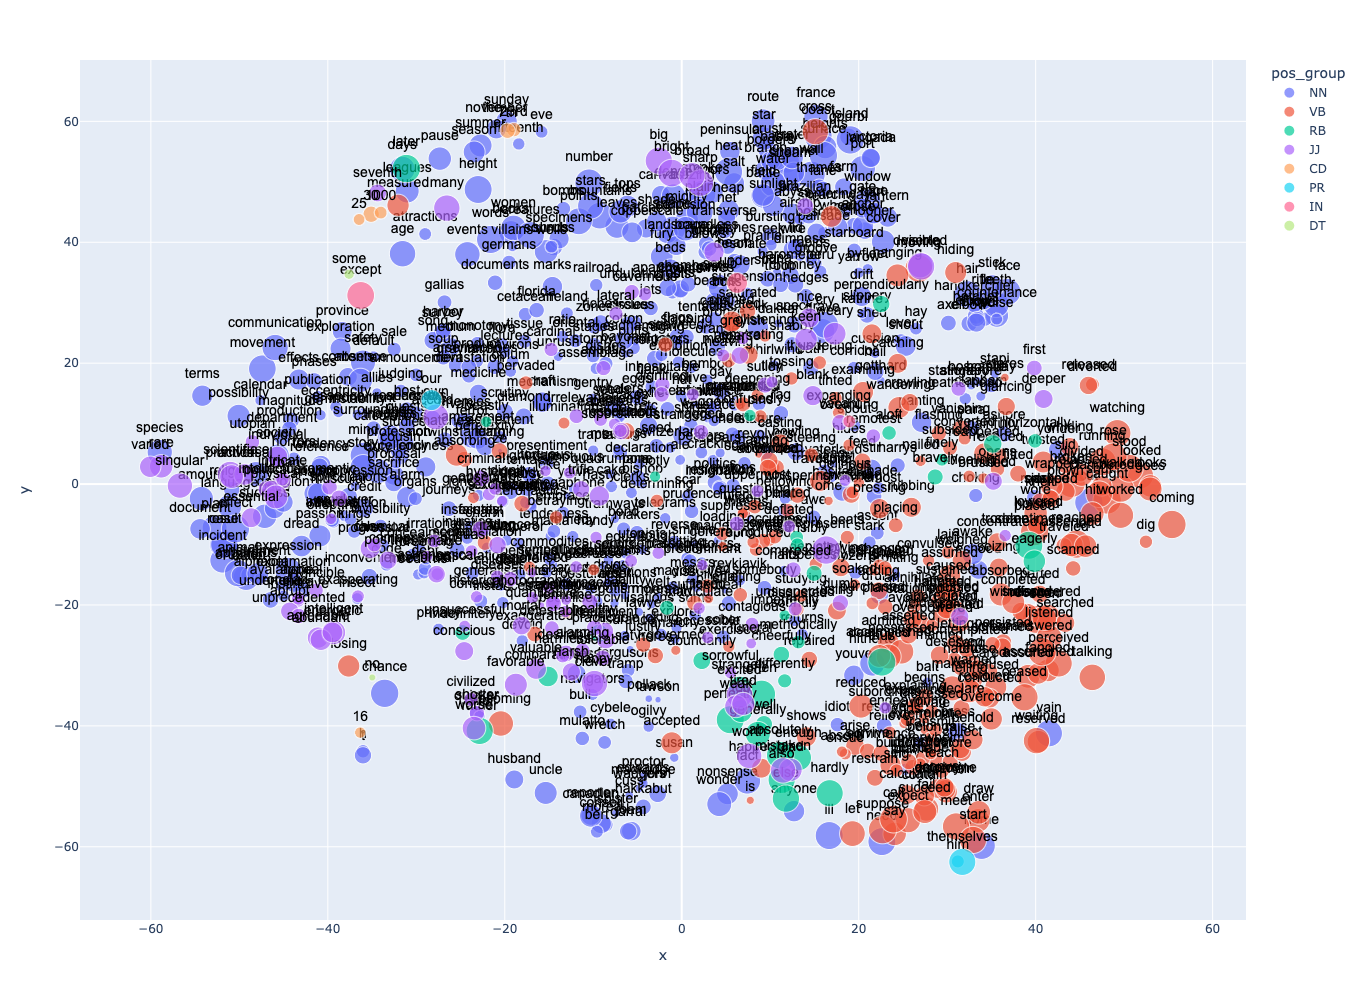

In [26]:
px.scatter(COORDS.reset_index().sample(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

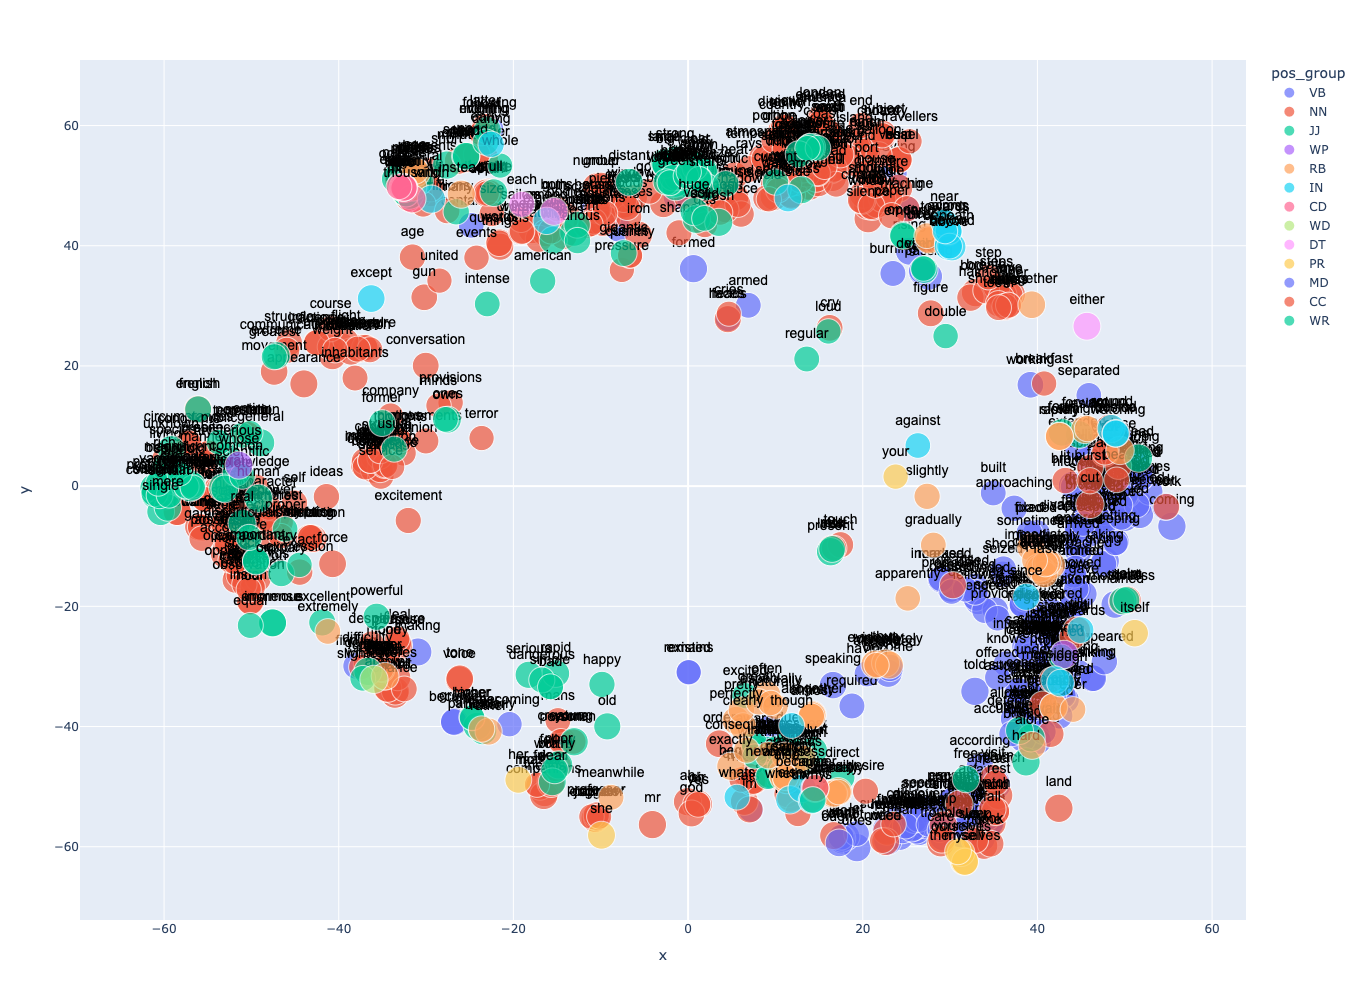

In [27]:
px.scatter(COORDS.reset_index().sort_values('dfidf', ascending=False).head(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Semantic Algebra

## Analogies

$A : B :: C : D? \rightarrow B - A + C = D$


In [28]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [29]:
complete_analogy('man', 'boy', 'woman', 3)

term       sim
0  dear  0.784719
1  boys  0.766941
2    ah  0.716184

In [30]:
complete_analogy('girl', 'daughter', 'boy', 3)

term       sim
0       father  0.830342
1  grandfather  0.800964
2         duty  0.789252

In [31]:
complete_analogy('girl', 'sister', 'boy', 3)

term       sim
0   excellency  0.811515
1       father  0.804504
2  grandfather  0.801235

In [32]:
complete_analogy('man', 'gentleman', 'woman', 5)

term       sim
0     wretch  0.764969
1     walter  0.739573
2    mulatto  0.737568
3       kahn  0.731744
4  frenchman  0.714432

In [33]:
complete_analogy('woman', 'lady', 'man', 5)

term       sim
0          bert  0.660584
1        torres  0.657483
2  passepartout  0.634433
3           jew  0.614554
4           fix  0.609239

In [34]:
complete_analogy('day', 'sun', 'night', 5)

term       sim
0       sky  0.737143
1     waves  0.720855
2   horizon  0.715618
3  twilight  0.703697
4      tide  0.691322

## Similarites

In [35]:
get_most_similar('joy')

term       sim
0       disgust  0.892055
1      laughter  0.864370
2          sigh  0.854423
3     amazement  0.837570
4  astonishment  0.834181
5        terror  0.833561
6        hoarse  0.829503
7        horror  0.824686
8         tones  0.822103
9     successor  0.821072

In [36]:
get_most_similar('man')

term       sim
0    invisible  0.745538
1     creature  0.716736
2          ape  0.714190
3          dog  0.712301
4        woman  0.709673
5     thickset  0.703440
6  unfortunate  0.685162
7      medical  0.679306
8        young  0.672930
9        dying  0.666793

In [37]:
get_most_similar(positive=['man'], negative=['woman'])

term       sim
0         him  0.443855
1  themselves  0.416346
2        keep  0.402410
3         off  0.399185
4          up  0.373189
5        them  0.365944
6     balloon  0.356149
7        back  0.355645
8       aside  0.349260
9     himself  0.346269

In [38]:
get_most_similar(positive='woman')

term       sim
0        young  0.840917
1         girl  0.806077
2       haired  0.784496
3        dying  0.775784
4     thickset  0.774507
5      mulatto  0.761422
6  unfortunate  0.757563
7     creature  0.756504
8        miner  0.751804
9         poor  0.751004

In [39]:
get_most_similar(positive=['woman'], negative=['man'])

term       sim
0        n  0.423484
1   marcus  0.419443
2        s  0.406684
3        1  0.406151
4        w  0.403688
5        3  0.399790
6        g  0.399388
7        c  0.396428
8        4  0.394761
9  roberts  0.391683

In [40]:
get_most_similar(['man','woman'],['boy','girl'])

term       sim
0     animal  0.436765
1       sort  0.417046
2  invisible  0.415257
3   enormous  0.380686
4    immense  0.380672
5     single  0.379447
6     living  0.358756
7       tree  0.336750
8    unknown  0.335361
9       kind  0.323568

# Save

In [41]:
W2V.to_csv(f'{data_home}/output/{data_prefix}-W2V.csv')
#VOCAB.to_csv(f'{data_home}/output/{data_prefix}-VOCAB.csv')
SENTS.to_csv(f'{data_home}/output/{data_prefix}-GENSIM_DOCS.csv')